# Clustering + PCA Assignment

### Problem Statement:

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

After the recent project that included a lot of awareness drives and funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid.

And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

<h2>Objectives</h2>

Your main task is to cluster the countries by the factors mentioned above and then present your solution and recommendations to the CEO using a PPT. You are also supposed to use dimensionality reduction using PCA to get the visualisations of the clusters in a 2-D form.

In [1]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
#Reading the dataset

aid = pd.read_csv("Country-data.csv")

aid.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
#Getting the shape and info of dataset
print(aid.shape)
print()
print(aid.info())

(167, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB
None


In [4]:
# Checking outliers at 25%,50%,75%,90%,95% and 99% for numerical columns
aid.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


As per the data understanding, columns such as **`exports, health and imports`** are given in terms of percentages. We can convert these percentages to absolute values by multiplying with **`gdpp`** column

In [5]:
#Converting exports, imports and health into absolute values
aid.exports = (aid.exports/100) * aid.gdpp
aid.imports = (aid.imports/100) * aid.gdpp
aid.health = (aid.health/100) * aid.gdpp
aid.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [6]:
#Checking for missing values
100*(aid.isnull().sum()/len(aid))

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

All data is free from missing values

Text(0.5, 1, 'Correlation Map Before PCA')

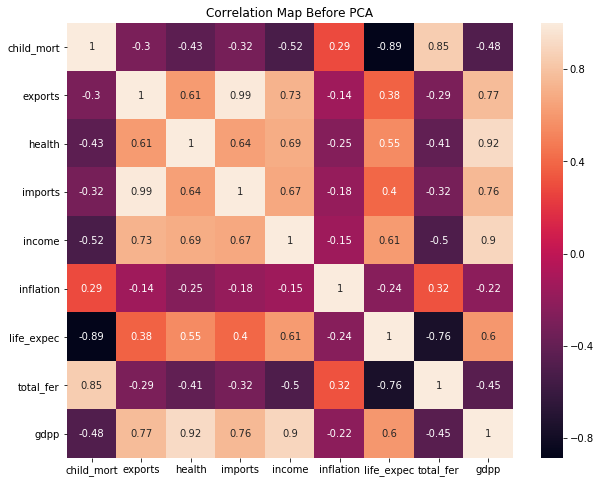

In [7]:
#Checking the correlation values for clustering
plt.figure(figsize=(10,8))
sns.heatmap(aid.corr(), annot=True)
plt.title('Correlation Map Before PCA')

From the above heatmap,
- We can see that some variables like imports-exports, income-gdpp, health-gdpp and child_mor-total_fer are having very high positive correlation coefficients
- These high correlations are insignificant for clustering. So instead of dropping these variables we'll perform PCA on the data and cluster with the principal components.

## Data Preparation

As we can see the **'Country'** column has all unique contry names, we can use this column further for identifying the clusters countrywise. So let's drop it now we can use this further

In [8]:
country_names = aid['country']

### Rescaling the Data

In [9]:
#Instantiate the scaler object
scaler = StandardScaler()

In [10]:
#Copy the dataframe to new variable to keep original dataframe
aid_copy = aid.drop('country',axis=1).copy()

In [11]:
#Fitting and transforming the data with scaler values
X = scaler.fit_transform(aid_copy)

## PCA

In [12]:
#Instantiating and applying the PCA by fitting the data 
pca = PCA(svd_solver = 'randomized', random_state = 42)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [13]:
#Checking the PCA components
pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [14]:
#Getting the variance information
pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

### Scree Plot

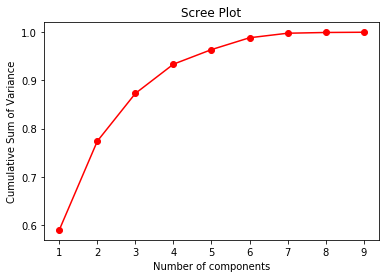

In [15]:
#Plotting the Scree plot of the variance information using cumulative function
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(cum_var)+1),cum_var,'ro-')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Sum of Variance')
plt.title("Scree Plot")
plt.show()

Let's take __5__ principal components and again perform PCA using 5 components

In [16]:
#Now using incremental PCA with 5 components and transforming the data
pca_final = IncrementalPCA(n_components = 5)
aid1 = pca_final.fit_transform(X)

In [17]:
#Getting the shape of the new data
aid1.shape

(167, 5)

In [18]:
# Generating a dataframe and checking the head of the same
aid2 = pd.DataFrame(aid1,columns=['PC1','PC2','PC3','PC4','PC5'])
aid2.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.636338,1.472260,-0.548330,0.238302,0.061003
1,-0.023783,-1.435535,-0.015470,-0.428278,-0.154305
2,-0.459228,-0.679705,0.956537,-0.193531,-0.092128
3,-2.723472,2.174966,0.597397,0.417695,0.056694
4,0.649103,-1.026404,-0.258645,-0.276882,0.077087


Text(0.5, 1, 'Correlation Map After PCA')

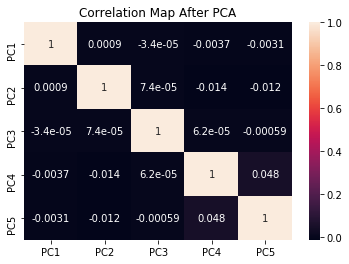

In [19]:
# Plotting the heatmap for checking the correlations obtained
sns.heatmap(aid2.corr(),annot=True)
plt.title('Correlation Map After PCA')

As you can see, now all the correlations are neutralized to zero

## Outlier Treatment

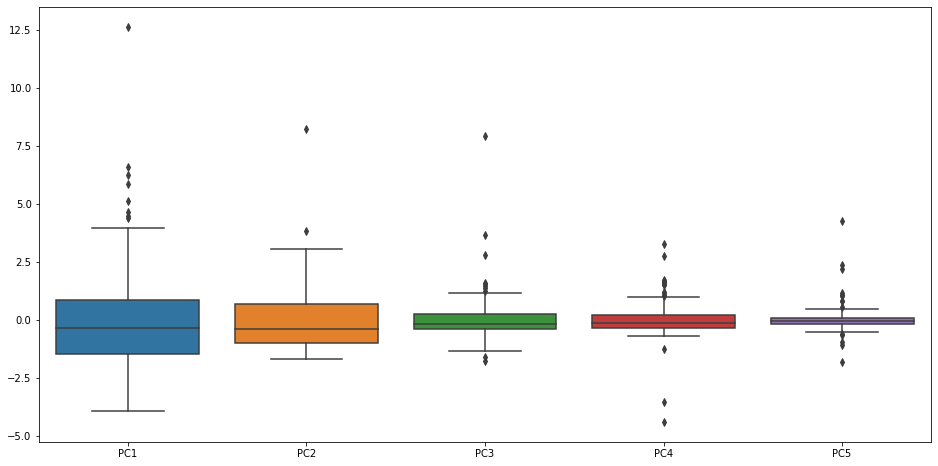

In [20]:
#Plotting the boxplot of each component to check for outliers
plt.figure(figsize=(16, 8))
sns.boxplot(data=aid2)

- From the above plots we can see that outliers are present in the data we shall deal the outliers by removing the data using IQR method
- As we are removing the rows, we need to identify which countries are removed,we will add the country column to identify that

In [21]:
#Adding the country column to this dataframe
aid2 = pd.concat([aid2,country_names], axis=1)
aid2.head()

,PC1,PC2,PC3,PC4,PC5,country
0,-2.636338,1.472260,-0.548330,0.238302,0.061003,Afghanistan
1,-0.023783,-1.435535,-0.015470,-0.428278,-0.154305,Albania
2,-0.459228,-0.679705,0.956537,-0.193531,-0.092128,Algeria
3,-2.723472,2.174966,0.597397,0.417695,0.056694,Angola
4,0.649103,-1.026404,-0.258645,-0.276882,0.077087,Antigua and Barbuda


In [22]:
# For PC1
Q1 = aid2.PC1.quantile(0.25)
Q3 = aid2.PC1.quantile(0.75)
IQR = Q3 - Q1
aid2 = aid2[(aid2.PC1 >= Q1 - 1.5 * IQR) & (aid2.PC1 <= Q3 + 1.5 * IQR)]

In [23]:
# For PC2
Q1 = aid2.PC2.quantile(0.25)
Q3 = aid2.PC2.quantile(0.75)
IQR = Q3 - Q1
aid2 = aid2[(aid2.PC2 >= Q1 - 1.5 * IQR) & (aid2.PC2 <= Q3 + 1.5 * IQR)]

In [24]:
# #For PC3
Q1 = aid2.PC3.quantile(0.25)
Q3 = aid2.PC3.quantile(0.75)
IQR = Q3 - Q1
aid2 = aid2[(aid2.PC3 >= Q1 - 1.5 * IQR) & (aid2.PC3 <= Q3 + 1.5 * IQR)]

In [25]:
# #For PC4
Q1 = aid2.PC4.quantile(0.25)
Q3 = aid2.PC4.quantile(0.75)
IQR = Q3 - Q1
aid2 = aid2[(aid2.PC4 >= Q1 - 1.5 * IQR) & (aid2.PC4 <= Q3 + 1.5 * IQR)]

In [26]:
# For PC5
Q1 = aid2.PC5.quantile(0.25)
Q3 = aid2.PC5.quantile(0.75)
IQR = Q3 - Q1
aid2 = aid2[(aid2.PC5 >= Q1 - 1.5 * IQR) & (aid2.PC5 <= Q3 + 1.5 * IQR)]

In [27]:
#Checking the shape now
aid2.shape

(131, 6)

In [28]:
#Dropping the country column now, will use it later
country_updated = aid2['country']
aid2 = aid2.drop('country',axis=1)
aid2.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.636338,1.472260,-0.548330,0.238302,0.061003
1,-0.023783,-1.435535,-0.015470,-0.428278,-0.154305
2,-0.459228,-0.679705,0.956537,-0.193531,-0.092128
3,-2.723472,2.174966,0.597397,0.417695,0.056694
4,0.649103,-1.026404,-0.258645,-0.276882,0.077087


Now that we have formed the principal components and removed outliers too, let's start with Kmeans Clustering first

In [29]:
#Before starting clustering let's calculate the Hopkin's Statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [30]:
hopkins(aid2)

0.8512000305103887

As the hopkins score is more than 0.75, the data is good enough for clustering

## K-Means Clustering

In [31]:
#Finding the kmeans for arbitrary value k=4
kmeans = KMeans(n_clusters=4, max_iter = 50, random_state = 42)
kmeans.fit(aid2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [32]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

Let's find the optimal cluster number using silhouette score and elbow curve to get better cluster number

### Finding the optimal number of clusters

#### Elbow Curve / SSD

Text(0.5, 1.0, 'Elbow Curve / SSD')

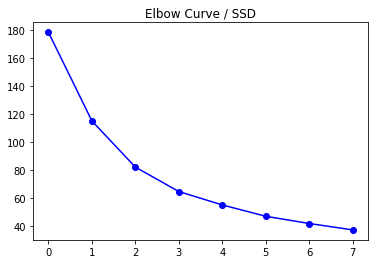

In [33]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9]

for n_clust in range_n_clusters:
    kmeans = KMeans(n_clusters = n_clust, max_iter = 50)
    kmeans.fit(aid2)
    
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd,'bo-')
plt.title('Elbow Curve / SSD')

As per the elbow curve, we can see the elbow at **3rd** cluster. We will also calculate the silhouette scores as well

#### Silhouette Analysis

If number of clusters = 2, the sihouette score is 0.52506185254913
If number of clusters = 3, the sihouette score is 0.4375525966320109
If number of clusters = 4, the sihouette score is 0.41808478416110134
If number of clusters = 5, the sihouette score is 0.3705036135139384
If number of clusters = 6, the sihouette score is 0.35294065517115075
If number of clusters = 7, the sihouette score is 0.3641577163206561
If number of clusters = 8, the sihouette score is 0.35208675172090803
If number of clusters = 9, the sihouette score is 0.3313677353133049


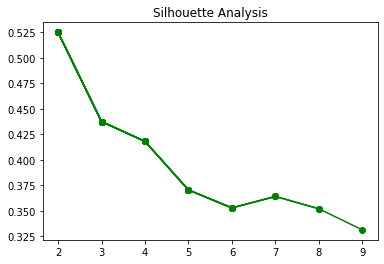

In [34]:
#Creating a list of number of clusters and finding the silhouette score for each number of clusters
range_n_clusters = [2,3,4,5,6,7,8,9]

sil=[]
for num_clust in range_n_clusters:
    
    #initialise kmeans
    kmeans = KMeans(n_clusters = num_clust, max_iter =50)
    kmeans.fit(aid2)
    
    cluster_labels = kmeans.labels_
    
    #silhouette score
    silhouette_avg = silhouette_score(aid2, cluster_labels)
    print("If number of clusters = {0}, the sihouette score is {1}".format(num_clust, silhouette_avg))
    
    #silhouette plot
    sil.append([num_clust, silhouette_score(aid2,cluster_labels)])
    plt.plot(pd.DataFrame(sil)[0], pd.DataFrame(sil)[1],'go-')
    
plt.title('Silhouette Analysis')
plt.show()

Eventhough the silhouette score is good for 2 clusters instead we will follow the elbow curve and define the optimal number of clusters as **`3`**

In [35]:
#Let's run the algorithm with optimal clusters k = 3

kmeans = KMeans(n_clusters = 3,max_iter = 50, random_state = 42)
kmeans.fit(aid2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [36]:
#Checking the labels
kmeans.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 1, 0, 2, 1,
       1, 2, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 1,
       2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 2, 2, 1, 0, 0, 1, 1,
       0, 0, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1])

In [37]:
#Creating a dataframe with cluster labels and country names updated
aid_kmean = pd.concat([pd.Series(kmeans.labels_, name='cluster_id', index=aid2.index),
                                  country_updated.loc[aid2.index]], axis=1)

In [38]:
#Now we will add back the country names to this clustered data
aid_kmean = pd.concat([aid2,aid_kmean], axis=1)
aid_kmean.head()

,PC1,PC2,PC3,PC4,PC5,cluster_id,country
0,-2.636338,1.472260,-0.548330,0.238302,0.061003,1,Afghanistan
1,-0.023783,-1.435535,-0.015470,-0.428278,-0.154305,2,Albania
2,-0.459228,-0.679705,0.956537,-0.193531,-0.092128,2,Algeria
3,-2.723472,2.174966,0.597397,0.417695,0.056694,1,Angola
4,0.649103,-1.026404,-0.258645,-0.276882,0.077087,2,Antigua and Barbuda


In [39]:
#Let's merge this formed dataframe to original dataframe
aid_kmean = pd.merge(aid_kmean,aid,how = 'inner', on='country')
aid_kmean.head()

,PC1,PC2,PC3,PC4,PC5,cluster_id,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,-2.636338,1.472260,-0.548330,0.238302,0.061003,1,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,-0.023783,-1.435535,-0.015470,-0.428278,-0.154305,2,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,-0.459228,-0.679705,0.956537,-0.193531,-0.092128,2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,-2.723472,2.174966,0.597397,0.417695,0.056694,1,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,0.649103,-1.026404,-0.258645,-0.276882,0.077087,2,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [40]:
aid_kmean.cluster_id.value_counts()

2    70
1    43
0    18
Name: cluster_id, dtype: int64

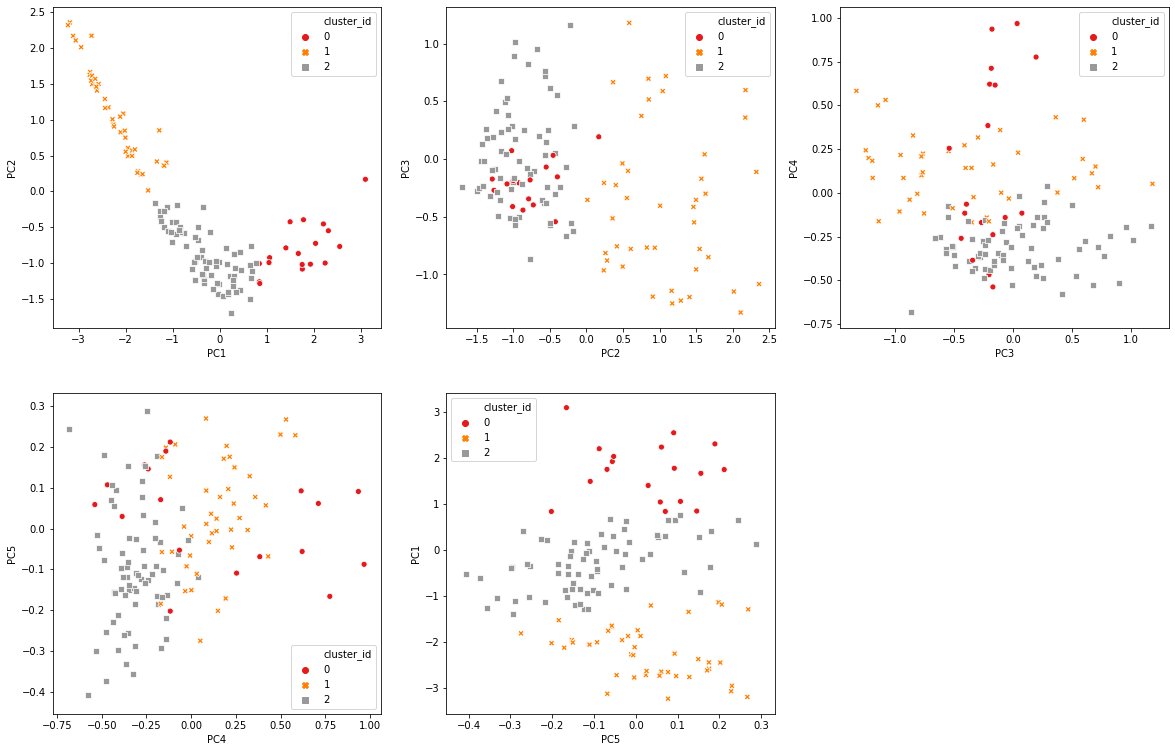

In [41]:
#Checking the cluster formation of all principal components
plt.figure(figsize=(20,13))

plt.subplot(2,3,1)
sns.scatterplot(x= 'PC1', y= 'PC2', hue='cluster_id',legend='full',style='cluster_id',palette='Set1', data=aid_kmean)

plt.subplot(2,3,2)
sns.scatterplot(x= 'PC2', y= 'PC3', hue='cluster_id',legend='full',style='cluster_id',palette='Set1', data=aid_kmean)

plt.subplot(2,3,3)
sns.scatterplot(x= 'PC3', y= 'PC4', hue='cluster_id',legend='full',style='cluster_id',palette='Set1', data=aid_kmean)

plt.subplot(2,3,4)
sns.scatterplot(x= 'PC4', y= 'PC5', hue='cluster_id',legend='full',style='cluster_id',palette='Set1', data=aid_kmean)

plt.subplot(2,3,5)
sns.scatterplot(x= 'PC5', y= 'PC1', hue='cluster_id',legend='full',style='cluster_id',palette='Set1', data=aid_kmean)


By visualising the principal components, 
- We can see that PC1 and PC2 components have formed clean three clusters
- All the other components have some overlapping clusters

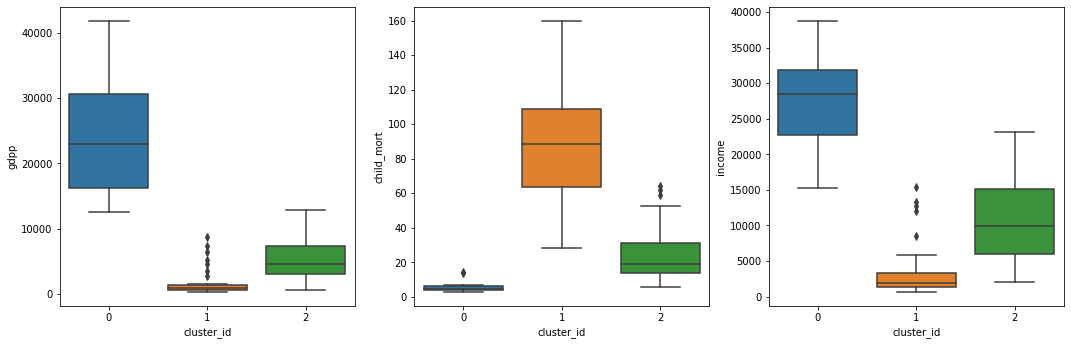

In [42]:
#Plotting boxplots to get the relations of cluster labels with original data
plt.figure(figsize=(18,5.5))

plt.subplot(1,3,1)
sns.boxplot(data=aid_kmean,y='gdpp' ,x='cluster_id')

plt.subplot(1,3,2)
sns.boxplot(data=aid_kmean,y='child_mort', x='cluster_id')

plt.subplot(1,3,3)
sns.boxplot(data=aid_kmean,y='income', x='cluster_id')

plt.show()


From the above boxplot,
- **`Cluster-0`** has the **`highest gdpp and income`** and also with the **`lowest child mortality`** of all other clusters. As per the spread, we can infer this cluster with the **`developed countries`**
- **`Cluster-1`** has the **`lowest gdpp and income`** and **`highest child mortality`**. We can infer this to be the cluster with **`under-developed countries`**
- Cluster-1 depicts to be the cluster we are looking for in this analysis having socio-economic and health factors. 
- **`Cluster-2`** has moderate of all the factors discussed above. We can infer this cluster with **`developing countries`** 

In [43]:
#List of all countries with dire need of aid
list_kmean = list(aid_kmean.country[aid_kmean.cluster_id==1])
list_kmean

['Afghanistan',
 'Angola',
 'Benin',
 'Botswana',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Eritrea',
 'Gabon',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Iraq',
 'Kenya',
 'Kiribati',
 'Lao',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mozambique',
 'Namibia',
 'Niger',
 'Pakistan',
 'Rwanda',
 'Senegal',
 'Sierra Leone',
 'Solomon Islands',
 'South Africa',
 'Sudan',
 'Tanzania',
 'Togo',
 'Uganda',
 'Yemen',
 'Zambia']

Let's perform hierarchical clustering to check if we can get any better results

## Hierarchical Clustering

In [44]:
#Checking the dataset for clustering
aid2.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.636338,1.472260,-0.548330,0.238302,0.061003
1,-0.023783,-1.435535,-0.015470,-0.428278,-0.154305
2,-0.459228,-0.679705,0.956537,-0.193531,-0.092128
3,-2.723472,2.174966,0.597397,0.417695,0.056694
4,0.649103,-1.026404,-0.258645,-0.276882,0.077087


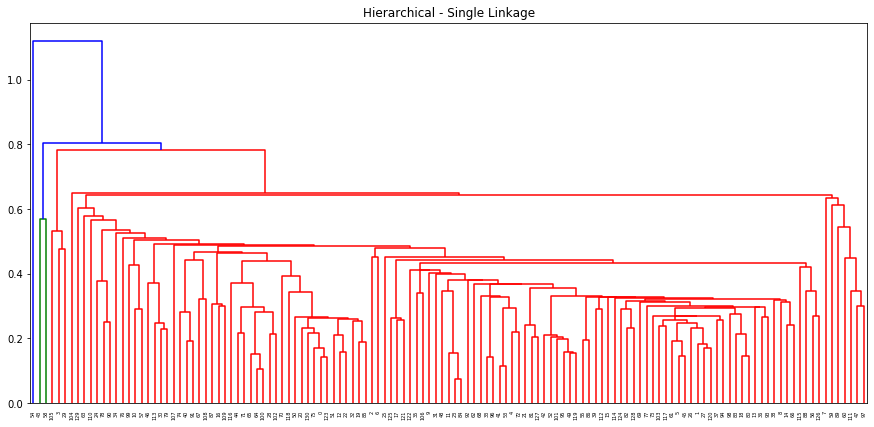

In [45]:
#Applying single linkage hierarchical technique
plt.figure(figsize=(15,7))
mergings = linkage(aid2, method="single", metric='euclidean')
dendrogram(mergings)
plt.title('Hierarchical - Single Linkage')
plt.show()

This plot doesn't help us to find the optimal clusters. Let's try with complete linkage

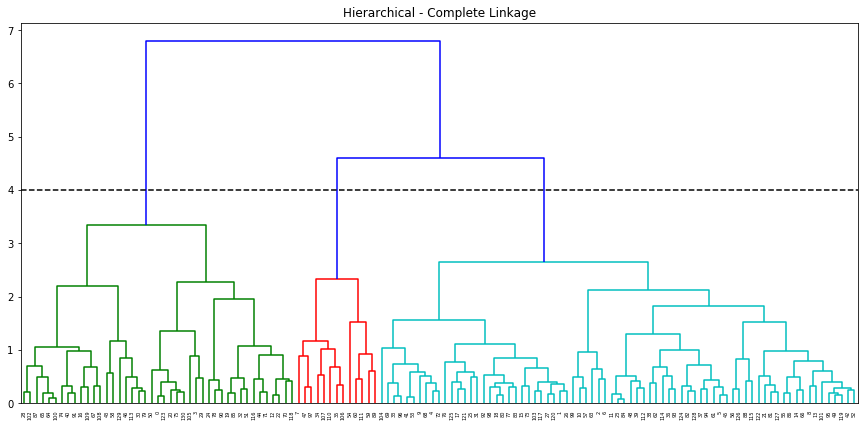

In [46]:
# Applying complete linkage technique
plt.figure(figsize=(15,7))
mergings = linkage(aid2, method="complete", metric='euclidean')
dendrogram(mergings,color_threshold=4)
plt.axhline(y=4, color='black', linestyle='--')
plt.title('Hierarchical - Complete Linkage')
plt.show()

Complete linkage dendrogram has formed **`three`** decent clusters. We can cut the tree at 4 to get three optimal clusters

In [47]:
#Let's cut the tree with 3 clusters and get cluster labels accordingly
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 2, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 0, 0,
       2, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0])

In [48]:
#Creating a dataframe with cluster labels and country names updated
aid_hier = pd.concat([pd.Series(cluster_labels, name='cluster_label', index=aid2.index),
                                  country_updated.loc[aid2.index]], axis=1)

In [49]:
#Now we will add back the country names to this clustered data 
aid_hier = pd.concat([aid2,aid_hier], axis=1)
aid_hier.head()

,PC1,PC2,PC3,PC4,PC5,cluster_label,country
0,-2.636338,1.472260,-0.548330,0.238302,0.061003,0,Afghanistan
1,-0.023783,-1.435535,-0.015470,-0.428278,-0.154305,1,Albania
2,-0.459228,-0.679705,0.956537,-0.193531,-0.092128,1,Algeria
3,-2.723472,2.174966,0.597397,0.417695,0.056694,0,Angola
4,0.649103,-1.026404,-0.258645,-0.276882,0.077087,1,Antigua and Barbuda


In [50]:
#Let's merge this formed dataframe to original dataframe
aid_hier = pd.merge(aid_hier,aid,how = 'inner', on='country')
aid_hier.head()

,PC1,PC2,PC3,PC4,PC5,cluster_label,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,-2.636338,1.472260,-0.548330,0.238302,0.061003,0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,-0.023783,-1.435535,-0.015470,-0.428278,-0.154305,1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,-0.459228,-0.679705,0.956537,-0.193531,-0.092128,1,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,-2.723472,2.174966,0.597397,0.417695,0.056694,0,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,0.649103,-1.026404,-0.258645,-0.276882,0.077087,1,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [51]:
#Checking the number of countries belonging to each cluster label
aid_hier.cluster_label.value_counts()

1    75
0    43
2    13
Name: cluster_label, dtype: int64

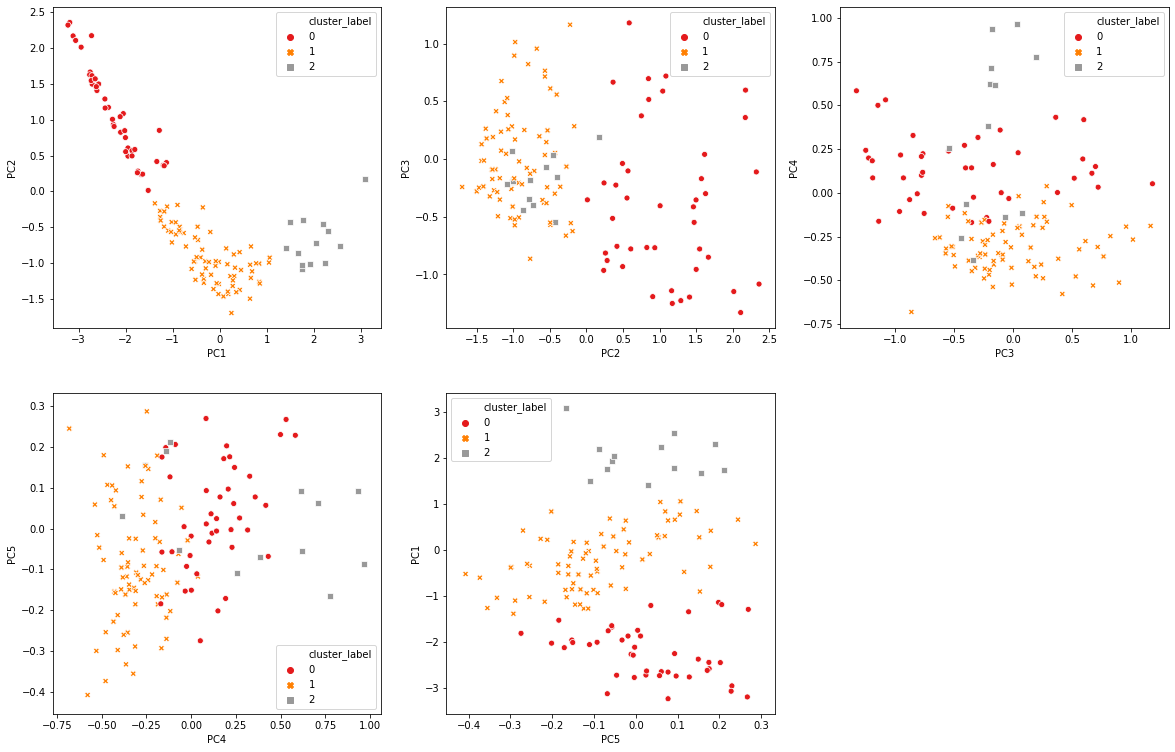

In [52]:
#Plotting all the principal components with cluster labels
plt.figure(figsize=(20,13))

plt.subplot(2,3,1)
sns.scatterplot(x= 'PC1', y= 'PC2', hue='cluster_label',legend='full',style='cluster_label',palette='Set1', data=aid_hier)

plt.subplot(2,3,2)
sns.scatterplot(x= 'PC2', y= 'PC3', hue='cluster_label',legend='full',style='cluster_label',palette='Set1', data=aid_hier)

plt.subplot(2,3,3)
sns.scatterplot(x= 'PC3', y= 'PC4', hue='cluster_label',legend='full',style='cluster_label',palette='Set1', data=aid_hier)

plt.subplot(2,3,4)
sns.scatterplot(x= 'PC4', y= 'PC5', hue='cluster_label',legend='full',style='cluster_label',palette='Set1', data=aid_hier)

plt.subplot(2,3,5)
sns.scatterplot(x= 'PC5', y= 'PC1', hue='cluster_label',legend='full',style='cluster_label',palette='Set1', data=aid_hier)

plt.show()

- In hierarchical clustering too, we are getting the similar distribution as we got in Kmeans clustering.

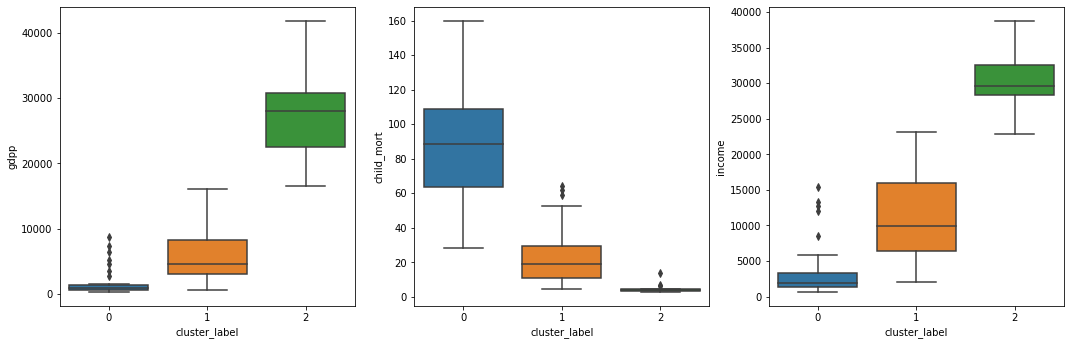

In [53]:
#Plotting boxplots to get the relations of cluster labels with original data
plt.figure(figsize=(18,5.5))

plt.subplot(1,3,1)
sns.boxplot(data=aid_hier,y='gdpp', x='cluster_label')

plt.subplot(1,3,2)
sns.boxplot(data=aid_hier,y='child_mort', x='cluster_label')

plt.subplot(1,3,3)
sns.boxplot(data=aid_hier,y='income', x='cluster_label')

plt.show()

- Again we are getting similar distribution as in Kmeans clustering only there is difference in cluster labels.
- Here, **`Cluster-0`** belongs to the **`under-developed countries`** and also need aid.
- **`Cluster-1`** comes under the **`developing countries`** which can soon become developed.
- **`Cluster-2`** is the **`developed countries`** cluster category. 

In [54]:
#List of all countries with dire need of aid
list_hier = list(aid_hier.country[aid_hier.cluster_label==0])
list_hier

['Afghanistan',
 'Angola',
 'Benin',
 'Botswana',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Eritrea',
 'Gabon',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Iraq',
 'Kenya',
 'Kiribati',
 'Lao',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mozambique',
 'Namibia',
 'Niger',
 'Pakistan',
 'Rwanda',
 'Senegal',
 'Sierra Leone',
 'Solomon Islands',
 'South Africa',
 'Sudan',
 'Tanzania',
 'Togo',
 'Uganda',
 'Yemen',
 'Zambia']

## KMeans v/s Hierarchical

In [55]:
set(list_kmean).difference(set(list_hier))

set()

In [56]:
set(list_hier).difference(set(list_kmean))

set()

Both the clusterings are giving **`same country names`** who are in direst need of aid

Let's get some inferences from the cluster size of both models before deciding the final model for profiling

In [57]:
#Checking the number of countries belonging to each cluster id's in kmeans
aid_kmean.cluster_id.value_counts()

2    70
1    43
0    18
Name: cluster_id, dtype: int64

In [58]:
#Checking the number of countries belonging to each cluster label in hierarchical
aid_hier.cluster_label.value_counts()

1    75
0    43
2    13
Name: cluster_label, dtype: int64

As we know from the boxplots plotted after each clustering models,
- Maximum number of countries belong to the developing category
- Next, comes the under-developed countries which we are looking to offer aid
- There are very less number of countries which are under the developed category
- This shows that there are very less countries who are developed. Out of all countries around **`one-third`** number of total countries are needing aid and approximately **`60%`** of all countries are still developing.



Let's select the **`Hierarchical model`** for cluster profiling

 ## Cluster Profiling

In [59]:
#Copying the dataframe for profiling and dropping principal components
aid_final = aid_hier.copy()
aid_final = aid_final.drop(['PC1', 'PC2', 'PC3', 'PC4','PC5'], axis = 1)
aid_final.head()

,cluster_label,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,1,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,0,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,1,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [60]:
aid_final.groupby('cluster_label').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_label,,,,,,,,,
0,86.900000,620.945233,98.498109,643.552488,3348.488372,9.508721,59.800000,4.972093,1569.860465
1,22.494667,2545.843847,382.335019,2828.606548,11162.933333,6.083453,72.824000,2.263733,5808.160000
2,4.930769,11521.323077,2466.470000,11732.953846,30361.538462,1.200769,79.569231,1.701538,27907.692308


- `Cluster 0` seems to be having countries with __high__ `child mortality rate`, `inflation`, `fertility rate` and __low__ `GDP Per Capita`, `income gdp contribution`, `export gdp contribution`, `health gdp contribution` and `life expectancy rate` which are __important socio-economic and health factors__ to determine if a country is in __`direst need of aid`__.

In [61]:
#Let's get the under-developed countries
aid_final = aid_final[aid_final.cluster_label==0]
aid_final.head()

,cluster_label,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,Afghanistan,90.2,55.300,41.9174,248.297,1610,9.440,56.2,5.82,553
3,0,Angola,119.0,2199.190,100.6050,1514.370,5900,22.400,60.1,6.16,3530
12,0,Benin,111.0,180.404,31.0780,281.976,1820,0.885,61.8,5.36,758
16,0,Botswana,52.5,2768.600,527.0500,3257.550,13300,8.920,57.1,2.88,6350
19,0,Burkina Faso,116.0,110.400,38.7550,170.200,1430,6.810,57.9,5.87,575


As we know the **`GDP-Per Capita &`** and **`Child Mortality`** are the key factors for the overall socio-economic development of the country, we shall select the countries based on the `gdpp` and `child_mort` values

In [62]:
#Sorting the dataframe based on the gdp per capita in the ascending order and child_mort in the descending order
aid_final.sort_values(['gdpp','child_mort'], ascending=[True,False], inplace=True)
aid_final.head()

,cluster_label,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
20,0,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231
71,0,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327
29,0,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334
90,0,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348
105,0,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399


Following are list of the countries which needs to be focussed with the top being the most

In [63]:
aid_final = aid_final.country.reset_index().drop('index', axis=1)
aid_final.index += 1
aid_final

,country
1,Burundi
2,Liberia
3,"Congo, Dem. Rep."
4,Niger
5,Sierra Leone
6,Madagascar
7,Mozambique
8,Malawi
9,Eritrea
10,Togo
